In [ ]:
#| default_exp fid

# FID

In [ ]:
#| export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from diffusers import UNet2DModel
from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [ ]:
set_seed(1103, False)

## Classifier

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

torch.Size([1, 32, 32])


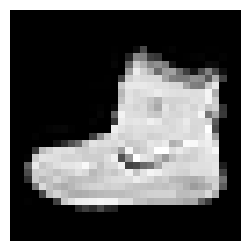

In [ ]:
img = ds["train"][0][fm_x]
img = TF.pad(TF.to_tensor(img), padding=2, fill=0, padding_mode="constant")
print(img.shape)
show_image(img, figsize=(3,3));

In [ ]:
@inplace
def transformi(b):
    b["image"] = [TF.pad(TF.to_tensor(i), padding=2, fill=0, padding_mode="constant") * 2 - 1 for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 64
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

In [ ]:
a = ()
a

()

In [ ]:
a += (1,)
a

(1,)

In [ ]:
#| export
@fc.patch
def capture_preds(self: Learner, inputs=False, preds=True, targets=True, to_tensor=True):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp])
    result = ()
    if inputs:
        result += (cp.captured_inps,)
    if preds:
        result += (cp.captured_preds,)
    if targets:
        result += (cp.captured_targets,)
    del cp
    if to_tensor:
        result = list(map(torch.cat, result))
    return result
        

In [ ]:
model = torch.load('models/14_aug_for_fid.pkl')
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()], opt_func=None)

In [ ]:
def append_outp(hook, mod, inp, outp):
    if not hasattr(hook, "out"):
        hook.out = []
    hook.out.append(to_cpu(outp))

In [ ]:
model[:-6:-1]

Sequential(
  (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=512, out_features=10, bias=True)
  (6): Flatten(start_dim=1, end_dim=-1)
  (5): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): GeneralReLU()
        (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (act): GeneralReLU()
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (id_conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (4): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), pa

In [ ]:
model[6]

Flatten(start_dim=1, end_dim=-1)

In [ ]:
out_hook = HooksCallback(append_outp, lambda x: x == model[6])

In [ ]:
learn.fit(1, train=False, cbs=[out_hook])

In [ ]:
out_hook.hooks[0].out[0].shape, out_hook.hooks[0].out[2].shape, out_hook.hooks[0].out[-1].shape

(torch.Size([64, 512]), torch.Size([64, 512]), torch.Size([16, 512]))

In [ ]:
del model[8]
del model[7]

In [ ]:
preds, targets = learn.capture_preds()
preds.shape, targets.shape

(torch.Size([10000, 512]), torch.Size([10000]))

## Calc FID

In [ ]:
class Schedule:
    def __init__(self, alphas, betas, alphas_bar, sigmas, n_steps):
        fc.store_attr()

def linear_sched(beta_min=0.0001, beta_max=0.02, n_steps=1000):
    betas = torch.linspace(beta_min, beta_max, n_steps)
    alphas = 1 - betas
    alphas_bar = torch.cumprod(alphas, 0)
    sigmas = betas.sqrt()
    return Schedule(alphas, betas, alphas_bar, sigmas, n_steps)

schedule = linear_sched()

def add_noise(x, schedule=schedule):
    device = x.device
    bs = x.shape[0]

    t = torch.randint(0, schedule.n_steps, (bs,), dtype=torch.int64)
    alpha_bar_t = schedule.alphas_bar[t][:, None, None, None].to(device)
    
    original_part = alpha_bar_t.sqrt() * x
    epsilon = torch.randn(x.shape, device=device)
    noise_part = (1 - alpha_bar_t).sqrt() * epsilon

    xt = original_part + noise_part
    return (xt, t.to(device)), epsilon

def get_collate_ddpm(schedule=schedule):
    def _collate_ddpm(b):
        return add_noise(default_collate(b)[fm_x], schedule)
    return _collate_ddpm

collate_ddpm = get_collate_ddpm(schedule)

def dl_ddpm(ds):
    return DataLoader(ds, batch_size=bs*2, collate_fn=collate_ddpm, num_workers=4)

def sample(model, sz, schedule=schedule):
    device = next(model.parameters()).device
    with torch.no_grad():
        x = torch.randn(sz, device=device)
        bs = x.shape[0]
        process = []

        for t in reversed(range(schedule.n_steps)):
            t_batch = torch.full((bs,), t, dtype=torch.int64)

            # Repametrized equation (4)
            noise_pred = model((x, t_batch.to(device)))
            alpha_bar_t = schedule.alphas_bar[t]
            x0_est = (x - (1 - alpha_bar_t).sqrt() * noise_pred) * (1 / alpha_bar_t.sqrt())
            x0_est = x0_est.clamp(0, 1)

            # Equations (7) and (8)
            alpha_bar_t_minus_1 = torch.tensor(1) if t == 0 else schedule.alphas_bar[t - 1]
            x0_coef = alpha_bar_t_minus_1.sqrt() * schedule.betas[t] / (1 - alpha_bar_t)
            xt_coef = schedule.alphas[t].sqrt() * (1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t)
            noise_sample = torch.zeros(x.shape, device=device) if t == 0 else torch.randn(x.shape, device=device)
            x = x0_coef * x0_est + x * xt_coef + schedule.sigmas[t] * noise_sample

            process.append(to_cpu(x))

    return process

class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample

In [ ]:
dls_fid = DataLoaders(dl_ddpm(dst["train"]), dl_ddpm(dst["test"]))

In [ ]:
diff_model = torch.load("models/17_ddpm_v2.pkl").to(def_device)

In [ ]:
set_seed(1103, False)
%time samples = sample(diff_model, (bs, 1, 32, 32))

CPU times: user 2min 3s, sys: 531 ms, total: 2min 3s
Wall time: 2min 3s


In [ ]:
samples[-1].min(), samples[-1].max()

(tensor(0.), tensor(0.9998))

In [ ]:
final = samples[-1] * 2 - 1

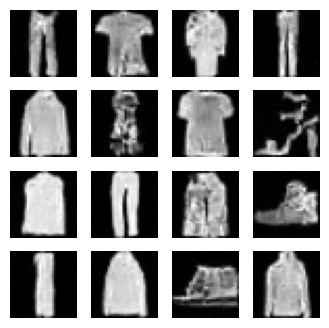

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
diff_learn = TrainLearner(model, DataLoaders([], [(final,yb)]), F.cross_entropy, cbs=[DeviceCB()], opt_func=None)
fid_preds, fid_targets = diff_learn.capture_preds()
fid_preds.shape

torch.Size([64, 512])

In [ ]:
fid_preds.cov().shape, fid_preds.mean(0).shape

(torch.Size([64, 64]), torch.Size([512]))

In [ ]:
#| export
def _calc_stats(feats):
    feats = feats.squeeze()
    return feats.mean(0), feats.T.cov()

https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance#Definition

In [ ]:
#| export
import scipy.linalg as linalg

In [ ]:
linalg.sqrtm?

Signature: linalg.sqrtm(A, disp=True, blocksize=64)
Docstring:
Matrix square root.

Parameters
----------
A : (N, N) array_like
    Matrix whose square root to evaluate
disp : bool, optional
    Print warning if error in the result is estimated large
    instead of returning estimated error. (Default: True)
blocksize : integer, optional
    If the blocksize is not degenerate with respect to the
    size of the input array, then use a blocked algorithm. (Default: 64)

Returns
-------
sqrtm : (N, N) ndarray
    Value of the sqrt function at `A`. The dtype is float or complex.
    The precision (data size) is determined based on the precision of
    input `A`. When the dtype is float, the precision is the same as `A`.
    When the dtype is complex, the precision is double that of `A`. The
    precision might be clipped by each dtype precision range.

errest : float
    (if disp == False)

    Frobenius norm of the estimated error, ||err||_F / ||A||_F

References
----------
.. [1] Edvin De

In [ ]:
cov_sqrt = linalg.sqrtm(preds.T.cov())
type(cov_sqrt.real), cov_sqrt.dtype, cov_sqrt.shape

(numpy.ndarray, dtype('float32'), (512, 512))

In [ ]:
#| export
def _calc_fid(m1, c1, m2, c2):
    cc =tensor(linalg.sqrtm(c1 @ c2).real)
    return (
        ((m1 - m2) ** 2).sum() +
        c1.trace() + c2.trace() - 2 * cc.trace()  # (c1 + c2 - 2 * cc).trace()
    ).item()

In [ ]:
preds.shape, fid_preds.shape

(torch.Size([10000, 512]), torch.Size([64, 512]))

In [ ]:
original_feats = preds
sampled_feats = fid_preds

In [ ]:
original_stats = _calc_stats(original_feats)
sampled_stats = _calc_stats(sampled_feats)
original_stats[1].shape, sampled_stats[1].shape

(torch.Size([512, 512]), torch.Size([512, 512]))

In [ ]:
_calc_fid(*sampled_stats, *original_stats)

90.146240234375

In [ ]:
_calc_fid(*original_stats, *original_stats)

-0.220458984375

https://arxiv.org/abs/1801.01401

In [ ]:
#| export
def _squared_mmd(x, y):
    x = x.squeeze()
    y = y.squeeze()
    def k(_x, _y):
        d = _x.shape[-1]
        return (1 / d * _x @ _y.T + 1) ** 3
    m = x.shape[0]
    n = y.shape[0]
    k_xx = k(x, x)
    k_yy = k(y, y)
    k_xy = k(x, y)
    return (
        ((1 / m / (m-1)) * (k_xx.sum() - k_xx.trace())) +
        ((1 / n / (n-1)) * (k_yy.sum() - k_yy.trace())) -
        ((2 / m / n) * k_xy.sum())
    ).item()

In [ ]:
_squared_mmd(original_feats[:3, :3], sampled_feats[:6, :3])

-21.29343605041504

In [ ]:
_squared_mmd(original_feats, sampled_feats)

0.1663985252380371

In [ ]:
#| export
def _calc_kid(x, y, maxs=50):
    return _squared_mmd(x, y)

In [ ]:
_calc_kid(original_feats, sampled_feats)

0.1663985252380371

In [ ]:
_calc_kid(original_feats, original_feats)

-0.0025343894958496094

## FID Class

In [ ]:
tensor([0]).shape, torch.empty(1).shape

(torch.Size([1]), torch.Size([1]))

In [ ]:
learn.capture_preds??

Signature: learn.capture_preds(inputs=False, preds=True, targets=True, to_tensor=True)
Docstring: <no docstring>
Source:   
@fc.patch
def capture_preds(self: Learner, inputs=False, preds=True, targets=True, to_tensor=True):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp])
    result = ()
    if inputs:
        result += (cp.captured_inps,)
    if preds:
        result += (cp.captured_preds,)
    if targets:
        result += (cp.captured_targets,)
    del cp
    if to_tensor:
        result = list(map(torch.cat, result))
    return result
File:      /tmp/ipykernel_2205/3369238615.py
Type:      method

In [ ]:
#| export
class ImageEval:
    def __init__(self, model, dls, cbs=None):
        self.learn = TrainLearner(model, dls, cbs=cbs, opt_func=None, loss_func=fc.noop)
        self.feats = self._get_feats()
        self.stats = _calc_stats(self.feats)

    def _get_feats(self):
        return to_cpu(self.learn.capture_preds()[0])
            
    def get_feats(self, samp):
        self.learn.dls = DataLoaders([], [(samp, torch.empty(1))])
        return self._get_feats()

    def fid(self, samp):
        return _calc_fid(*self.stats, *_calc_stats(self.get_feats(samp)))

    def kid(self, samp):
        return _calc_kid(self.feats, self.get_feats(samp))

In [ ]:
image_eval = ImageEval(model, learn.dls, cbs=[DeviceCB()])

In [ ]:
%time image_eval.fid(final), image_eval.kid(final)

CPU times: user 4.7 s, sys: 3.02 s, total: 7.72 s
Wall time: 1.02 s


(90.168701171875, 0.1663985252380371)

In [ ]:
len(samples)

1000

In [ ]:
to_eval = list(range(0, 900, 50)) + list(range(900, 990, 10)) + [990, 995, 999]
len(to_eval)

30

In [ ]:
%time fids = [image_eval.fid(samples[i] * 2 - 1) for i in to_eval]

CPU times: user 1min 17s, sys: 58.9 s, total: 2min 16s
Wall time: 13.8 s


In [ ]:
%time kids = [image_eval.kid(samples[i] * 2 - 1) for i in to_eval]

CPU times: user 1min 4s, sys: 10.5 s, total: 1min 14s
Wall time: 15.6 s


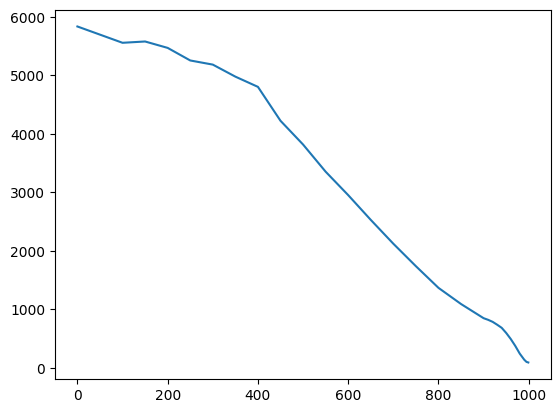

In [ ]:
plt.plot(to_eval, fids);

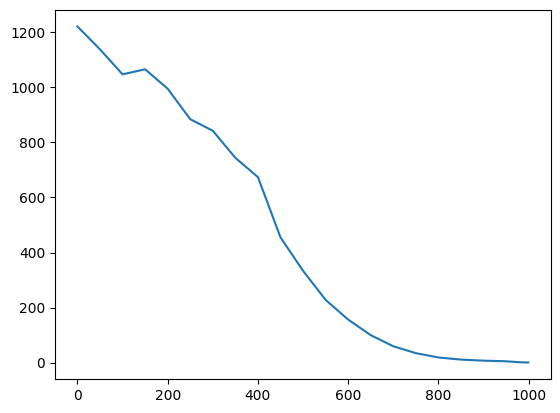

In [ ]:
plt.plot(to_eval, kids);

In [ ]:
image_eval.fid(samples[-1] * 2 - 1), image_eval.kid(samples[-1] * 2 - 1)

(90.168701171875, 0.1663985252380371)

In [ ]:
image_eval.fid(xb), image_eval.kid(xb)

(64.5721435546875, 0.044045448303222656)

## Inception

In [ ]:
from pytorch_fid.inception import InceptionV3

In [ ]:
InceptionV3?

Init signature:
InceptionV3(
    output_blocks=(3,),
    resize_input=True,
    normalize_input=True,
    requires_grad=False,
    use_fid_inception=True,
)
Docstring:      Pretrained InceptionV3 network returning feature maps
Init docstring:
Build pretrained InceptionV3

Parameters
----------
output_blocks : list of int
    Indices of blocks to return features of. Possible values are:
        - 0: corresponds to output of first max pooling
        - 1: corresponds to output of second max pooling
        - 2: corresponds to output which is fed to aux classifier
        - 3: corresponds to output of final average pooling
resize_input : bool
    If true, bilinearly resizes input to width and height 299 before
    feeding input to model. As the network without fully connected
    layers is fully convolutional, it should be able to handle inputs
    of arbitrary size, so resizing might not be strictly needed
normalize_input : bool
    If true, scales the input from range (0, 1) to the rang

In [ ]:
a = torch.zeros(3, 1, 2, 2)
a.shape

torch.Size([3, 1, 2, 2])

In [ ]:
a.repeat(1, 3, 1, 1).shape

torch.Size([3, 3, 2, 2])

In [ ]:
class IncepWrap(nn.Module):
    def __init__(self):
        super().__init__()
        self.inception = InceptionV3()

    def forward(self, x):
        return self.inception(x.repeat(1, 3, 1, 1))[0]

In [ ]:
image_eval = ImageEval(IncepWrap(), dls, cbs=[DeviceCB()])

In [ ]:
%time image_eval.fid(final), image_eval.kid(final)

CPU times: user 38.8 s, sys: 14.7 s, total: 53.5 s
Wall time: 8.69 s


(140.7357940673828, 0.03495073318481445)

In [ ]:
image_eval.fid(xb), image_eval.kid(xb)

(98.23300170898438, -0.00020575523376464844)

# Export

In [ ]:
import nbdev; nbdev.nbdev_export()